# 1. Study Stationarity

## What is starionarity?
A time series data is stationary if there is no obvious trend in the data. For example, a monotonically increasing data will not be stationary.

##### A stationary dataset
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/12/Daily-Female-Births-Dataset-Plot.png" alt="stationary" style="width: 400px;"/>

##### A Non-stationary dataset
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/12/Non-Stationary-Airline-Passengers-Dataset.png" alt="stationary" style="width: 400px;"/>

## Why is this needed?
There is a `d` parameter in ARIMA. We need this to set this parameter to fix non-stationary data.

## How to test for stationarity?
We can do this statistically. We'll be running an augmented dickey-fuller test to check if the data is stationary. 

Null hypothesis: The data is non-stationary  

If p<0.05, then we reject the null hypothesis, the data is stationary. Otherwise, it is non-stationary. 

In [106]:
from pathlib import Path
from data.data_handler import DataHandler
from pdb import set_trace
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
import numpy
data_handler = DataHandler(data_path=Path('data'))
files = data_handler.get_data()

for proj, data in files.items():
    print(proj.upper())
    print(len(proj)*"-")
    X = data.values.ravel()
    result = adfuller(X, autolag=None)
    print('p-value: {}. Stationary: {}\n'.format(round(result[1], 4), result[1] < 0.05))


ABINIT
------
p-value: 0.4398. Stationary: False

MDANALYSIS
----------
p-value: 0.0347. Stationary: True

LAMMPS
------
p-value: 0.2779. Stationary: False

LIBMESH
-------
p-value: 0.0485. Stationary: True



# 2. Extended Autocorrelation.

We'll need these to determine the p and q values in ARIMA.

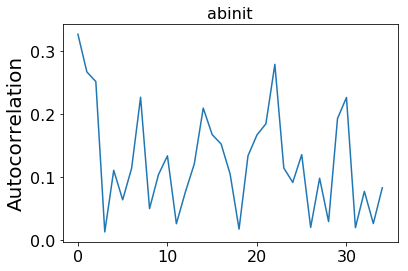

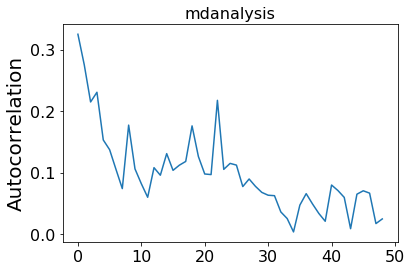

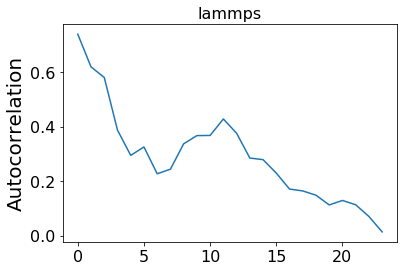

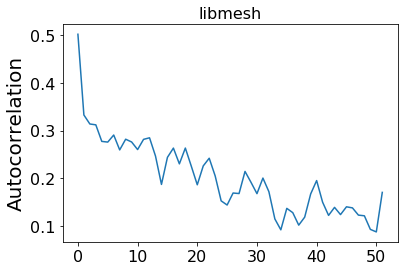

In [7]:
%matplotlib inline

from pathlib import Path
from data.data_handler import DataHandler
from pdb import set_trace
import matplotlib.pyplot as plt

data_handler = DataHandler(data_path=Path('data'))
files = data_handler.get_data()

def df_rolling_autocorr(df, lag):
    """
    Compute rolling column-wise autocorrelation for a DataFrame.
    """
    return df.apply(lambda col: col.autocorr(lag)).values[0]

for proj, data in files.items():
    autocorr = []
    for lag in range(1, 53):
        res = df_rolling_autocorr(data, lag)
        if res > 0:
            autocorr.append(res)
    
    plt.plot(autocorr)
    plt.ylabel('Autocorrelation')
    plt.title(proj)
    plt.show()
    
    
    

# 3. Detrending Data

Removing trends from the data is necessary to run timeseries analysis. We can do this two ways:

1. By using linear regression (or polynomial depending on the data) and then using the residuals.
2. Easier, just take the second differential.


In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import diff
from sklearn.linear_model import LinearRegression

# Second differential detrending
# ------------------------------

dy = 1.2
vals = np.exp(np.array([0.0, 0.0, 1.0986122886681098, 1.3862943611198906, 1.0986122886681098, 0.0, 1.9459101490553132, 1.6094379124341003, 2.3978952727983707, 2.833213344056216, 0.6931471805599453, 2.0794415416798357, 0.0, 3.295836866004329, 1.6094379124341003, 1.6094379124341003, 0.6931471805599453, 1.3862943611198906, 2.3978952727983707, 1.6094379124341003, 1.6094379124341003, 2.6390573296152584, 2.1972245773362196, 2.70805020110221]))
dval = list(abs(diff(diff(vals))/dy)/dy)
dval = [0,0] + dval

# Linear Regression Residual Detrending
# -------------------------------------

X = np.arange(len(vals))
X = numpy.reshape(X, (len(X), 1))
y = vals
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)  # calculate trend
lr_resid = [abs(v-t) for v,t in zip(vals, trend)]
lr_resid = [0,0]+ list(abs(diff(diff(lr_resid)))) 


# Measure stationarity with dickey-fuller test
# --------------------------------------------

result_actual = adfuller(vals, autolag=None)
result_dtrend = adfuller(dval, autolag=None)
result_lresid = adfuller(lr_resid, autolag=None)
print('p-value      Actual: {}. Stationary: {}\n'.format(round(result_actual[1], 5), result[1] < 0.05))
print('p-value    2nd Diff: {}. Stationary: {}\n'.format(round(result_dtrend[1], 5), result[1] < 0.05))
print('p-value LR residual: {}. Stationary: {}\n'.format(round(result_lresid[1], 5), result[1] < 0.05))

# Plot results
# ------------

plt.plot(vals)
plt.plot(dval)
plt.plot(lr_resid)
plt.legend(['Raw', '2nd Diff', 'LR Residual'])
plt.ylabel('Autocorrelation')
plt.title("Detrending Data")
plt.show()


ModuleNotFoundError: No module named 'sklearn'

# Compare error rates between ARIMA (4,1,4) and Naive Approach

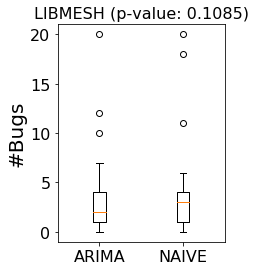

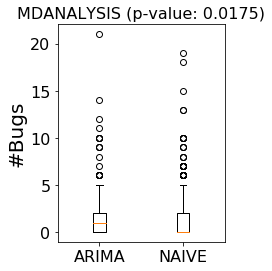

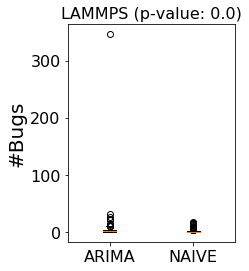

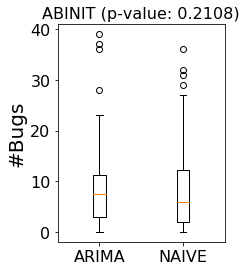

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from glob2 import glob
from pathlib import Path
from pdb import set_trace
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu as ranksum

# Setup Matplotlib
# ----------------

# Font sizes
# ----------
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 36
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Plot error rate comparisons and difference
# ------------------------------------------
for file in glob('results/*.csv'):
    plt.figure(figsize=(3,4))
    fname = Path(file).name[:-4]
    data = pd.read_csv(file)
    arima_err = abs(data['Actual']-data['ARIMA'])
    naive_err = abs(data['Actual']-data['NAIVE'])
    _, pval = ranksum(arima_err, naive_err)
    plt.boxplot([arima_err, naive_err], labels=['ARIMA', 'NAIVE'])
    plt.ylabel('#Bugs')
    plt.title(fname.upper()+" (p-value: {})".format(round(pval, 4)))
    plt.show()

# 4. Compare Forecast trends

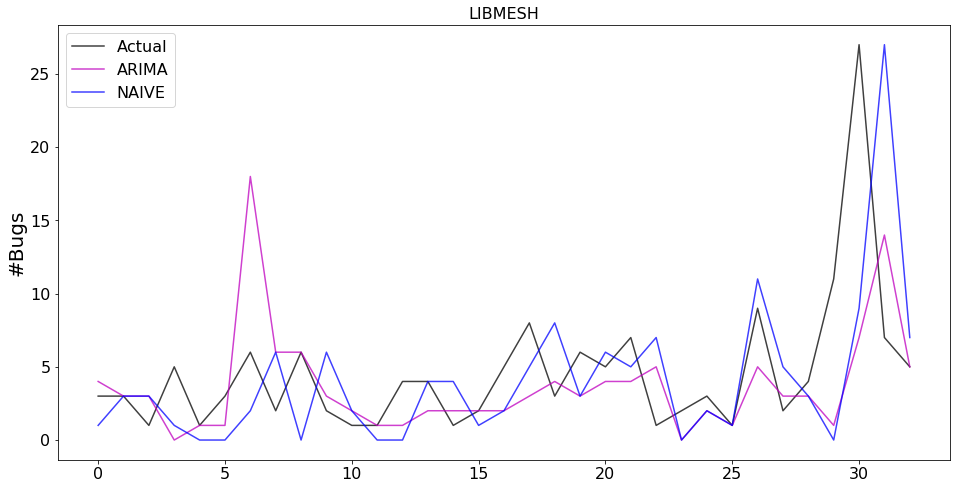

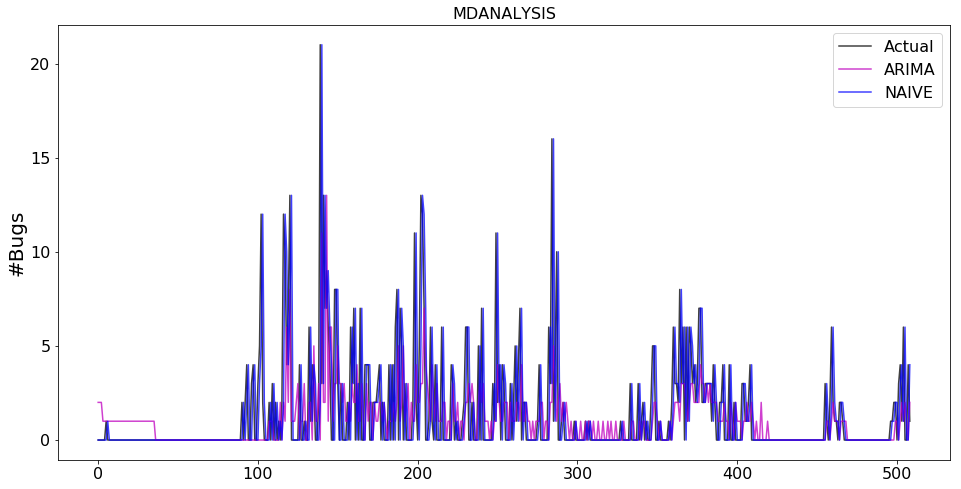

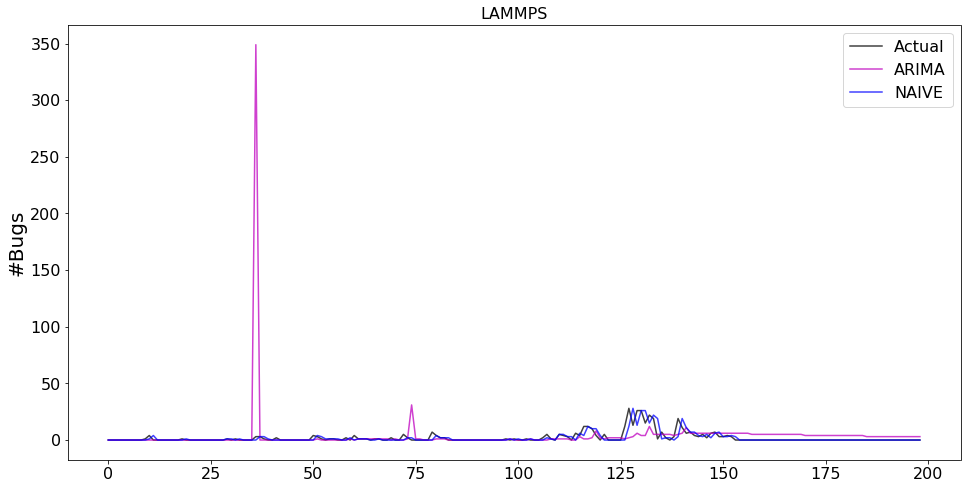

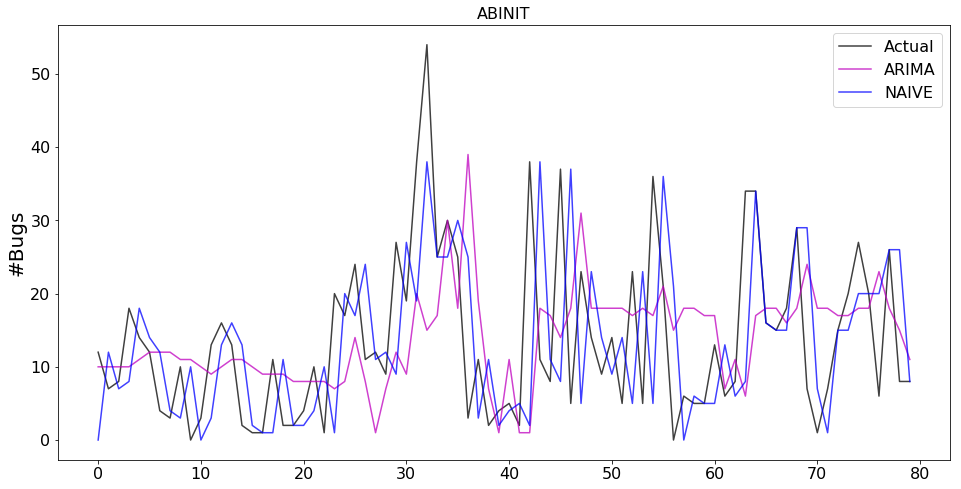

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
from glob2 import glob
from pathlib import Path
from pdb import set_trace
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu as ranksum

# Setup Matplotlib
# ----------------

# Font sizes
# ----------
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 36
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Plot forecast trends
# --------------------

for file in glob('results/*.csv'):
    plt.figure(figsize=(16,8))
    fname = Path(file).name[:-4]
    data = pd.read_csv(file)
    plt.plot(data['Actual'], color='k', alpha=0.75)#, abinit['ARIMA'], abinit['NAIVE'])
    plt.plot(data['ARIMA'] , color='m', alpha=0.75)#, abinit['ARIMA'], abinit['NAIVE'])
    plt.plot(data['NAIVE'] , color='b', alpha=0.75)#, abinit['ARIMA'], abinit['NAIVE'])
    plt.ylabel('#Bugs')
    plt.legend()
    # plt.xticks(range(len(data)), data['Date'], rotation=90)
    plt.title(fname.upper())
    plt.show()
